# Project: Neural Machine Translation of Languages

Project Status: On-going. Working on NMT using RNN to translate English into French.

This project is a proof of concept project to study neural machine translation (NMT) by making deep learning models translating the English language into the French language. In the future, I plan to see the how the model gets affected by reversing the source and target languages. I also plan to expand this project to include additional languages.

#### By: Eric J. Puttock
#### Last Updated: 2020.09.04

# Load in all libraries that will be used.

Import all libaries needed for this project here all at once. Gives you an overview of all packages used for this project.

In [1]:
import pandas as pd

import numpy as np

import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Model
from keras.layers import RepeatVector, GRU, TimeDistributed
from keras.layers.core import Dense


### Load in the data:

In [2]:
with open('vocab_en.txt','r', encoding="utf-8") as f_en:
    en_text = f_en.readlines()
with open('vocab_fr.txt','r', encoding="utf-8") as f_fr:
    fr_text = f_fr.readlines()

In [3]:
backup_en_text = en_text.copy()
backup_fr_text = fr_text.copy()

In [4]:
from string import punctuation
import re
filters = punctuation +'\n'+'>'+'<'+'+'
def RemovePunctutation(sentence):
    return ''.join(s for s in sentence if s not in filters)
def RemoveSpace(sentence):
    return re.sub('  ',' ',sentence).strip().lower()
def FilterProcess(sentence):
    return RemoveSpace(RemovePunctutation(sentence))

In [5]:
en_text = list(map(FilterProcess,en_text))
fr_text = list(map(FilterProcess,fr_text))

In [6]:
en_text = ['sos '+sent+' eos' for sent in en_text]
fr_text = ['sos '+sent+' eos' for sent in fr_text]

In [7]:
print(len(en_text),len(fr_text))

137860 137860


In [8]:
en_sent_lengths = [len(en_sent.split(" ")) for en_sent in en_text]
en_mean_length = np.mean(en_sent_lengths)
print('(English) Mean sentence length: ', en_mean_length)

(English) Mean sentence length:  13.26144639489337


In [9]:
en_all_words = []
for sent in en_text:
    en_all_words.extend(sent.split(" "))
en_vocab_size = len(set(en_all_words))
print("(English) Vocabulary size: ", en_vocab_size)

(English) Vocabulary size:  201


In [10]:
fr_sent_lengths = [len(fr_sent.split(" ")) for fr_sent in fr_text]
fr_mean_length = np.mean(fr_sent_lengths)
print('(French) Mean sentence length: ', fr_mean_length)

(French) Mean sentence length:  14.34153489046859


In [11]:
fr_all_words = []
for sent in fr_text:
    fr_all_words.extend(sent.split(" "))
fr_vocab_size = len(set(fr_all_words))
print("(French) Vocabulary size: ", fr_vocab_size)

(French) Vocabulary size:  347


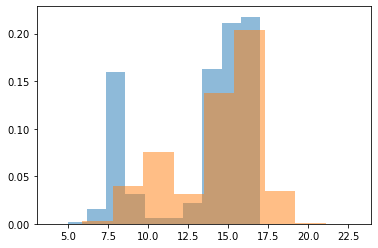

In [12]:
_=plt.hist(en_sent_lengths, alpha = 0.5, density = True)
_=plt.hist(fr_sent_lengths, alpha = 0.5, density = True)
plt.show()

# Split the Data into Train, Validation, Test Sets

In [50]:
# Split the data between training, validation, and hold-off test sets.

# Initialize index set, and randomize it. Then, sample the sets.
inds = np.arange(len(en_text))
np.random.seed(42)
np.random.shuffle(inds)

TestValidSize = round(len(en_text)*.75)
test_size = len(en_text)-TestValidSize

train_size = round(TestValidSize*.66)
valid_size = TestValidSize - train_size
#train_size, valid_size = 800, 200

print(train_size, valid_size, test_size)

# Training Set:
train_inds = inds[:train_size]
valid_inds = inds[train_size:train_size+valid_size]
tr_en = [en_text[ti] for ti in train_inds]
tr_fr = [fr_text[ti] for ti in train_inds]

# Validation Set:
v_en = [en_text[ti] for ti in valid_inds]
v_fr = [fr_text[ti] for ti in valid_inds]

# Test Set:
test_inds = inds[train_size+valid_size:]
te_en = [en_text[ti] for ti in test_inds]
te_fr = [fr_text[ti] for ti in test_inds]

68241 35154 34465


In [14]:
Tr_en_sent_lengths = [len(en_sent.split(" ")) for en_sent in tr_en]
Tr_en_mean_length = np.mean(Tr_en_sent_lengths)
print('(English) Train Mean sentence length: ', Tr_en_mean_length)

(English) Train Mean sentence length:  13.258012045544467


In [15]:
Tr_en_all_words = []
for sent in tr_en:
    Tr_en_all_words.extend(sent.split(" "))
Tr_en_vocab_size = len(set(Tr_en_all_words))
print("(English) Train Vocabulary size: ", Tr_en_vocab_size)

(English) Train Vocabulary size:  201


In [16]:
Tr_fr_sent_lengths = [len(fr_sent.split(" ")) for fr_sent in tr_fr]
Tr_fr_mean_length = np.mean(Tr_fr_sent_lengths)
print('(French) Train Mean sentence length: ', Tr_fr_mean_length)

(French) Train Mean sentence length:  14.34430913966677


In [17]:
Tr_fr_all_words = []
for sent in tr_fr:
    Tr_fr_all_words.extend(sent.split(" "))
Tr_fr_vocab_size = len(set(Tr_fr_all_words))
print("(French) Train Vocabulary size: ", Tr_fr_vocab_size)

(French) Train Vocabulary size:  342


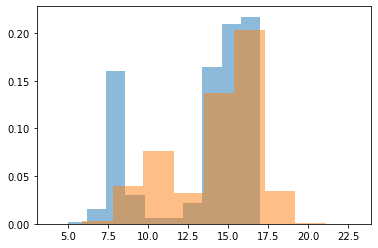

In [18]:
_=plt.hist(Tr_en_sent_lengths, alpha = 0.5, density = True)
_=plt.hist(Tr_fr_sent_lengths, alpha = 0.5, density = True)
plt.show()

# Hyperparameters:

In [19]:
# Text Hyperparamters:
en_len = 20
en_vocab = 200

fr_len = 20
fr_vocab = 350

en_hsize = 64
fr_hsize = 64

### Tokenize the data:

In [20]:
#en_tok = Tokenizer()
en_tok = Tokenizer(num_words = en_vocab+1, oov_token = 'UNK')
en_tok.fit_on_texts(tr_en)

#fr_tok = Tokenizer()
fr_tok = Tokenizer(num_words = fr_vocab+1, oov_token = 'UNK')
fr_tok.fit_on_texts(tr_fr)

In [21]:
print(len(en_tok.word_index))

202


In [22]:
print(len(fr_tok.word_index))

342


# Remark: 
This is a bug in Tokenizer that is addressed on GitHub: https://github.com/keras-team/keras/issues/8092 .
- The number of words in the tokenizer is not equal to the num_words we originally wanted.
- We need to manually sort this out (at the expense of losing a little bit) by following the procedure described in the link.
- We will also have to update index_word accordingly.

In [23]:
en_tok.word_index = {e:i for e,i in en_tok.word_index.items() if i <= en_vocab} # <= because tokenizer is 1 indexed
en_tok.word_index[en_tok.oov_token] = 1

In [24]:
en_tok.index_word = {v:k for k,v in en_tok.word_index.items()}

In [25]:
fr_tok.word_index = {e:i for e,i in fr_tok.word_index.items() if i <= fr_vocab} # <= because tokenizer is 1 indexed
fr_tok.word_index[fr_tok.oov_token] = 1

In [26]:
fr_tok.index_word = {v:k for k,v in fr_tok.word_index.items()}

In [27]:
print(len(en_tok.word_index))

200


In [28]:
print(len(fr_tok.word_index))

342


In [29]:
for j in range(0,10):
    print(en_text[j])
    print(' '.join(en_tok.index_word[s] for s in en_tok.texts_to_sequences([en_text[j]])[0]) + '\n')
    print('\t' + fr_text[j])
    print('\t' + ' '.join(fr_tok.index_word[s] for s in fr_tok.texts_to_sequences([fr_text[j]])[0])+'\n')

sos new jersey is sometimes quiet during autumn and it is snowy in april eos
sos new jersey is sometimes quiet during autumn and it is snowy in april eos

	sos new jersey est parfois calme pendant l automne et il est neigeux en avril eos
	sos new jersey est parfois calme pendant l automne et il est neigeux en avril eos

sos the united states is usually chilly during july and it is usually freezing in november eos
sos the united states is usually chilly during july and it is usually freezing in november eos

	sos les étatsunis est généralement froid en juillet et il gèle habituellement en novembre eos
	sos les étatsunis est généralement froid en juillet et il gèle habituellement en novembre eos

sos california is usually quiet during march and it is usually hot in june eos
sos california is usually quiet during march and it is usually hot in june eos

	sos california est généralement calme en mars et il est généralement chaud en juin eos
	sos california est généralement calme en mars et

There, we appropriately fixed it. Words not in the top fr_vocab in frequency, they should become UNK.

### Pre-process the data:

In [30]:
# Add new keyword parameter reverse which defaults to False
def sents2seqs(sentences, lang='en', pad_type='post', reverse=False, onehot=False):     
    if lang == 'en':
        encoded_text = en_tok.texts_to_sequences(sentences)
        preproc_text = pad_sequences(encoded_text, padding=pad_type, truncating='post', maxlen=en_len)
        if reverse:
            # Reverse the text using numpy axis reversing
            preproc_text = preproc_text[:,::-1]
        if onehot: # +1 (added padding for 0's) + 1 (added 'UNK')
            preproc_text = to_categorical(preproc_text, num_classes=en_vocab+1+1)
    
    if lang == 'fr':
        encoded_text = fr_tok.texts_to_sequences(sentences)
        preproc_text = pad_sequences(encoded_text, padding=pad_type, truncating='post', maxlen=fr_len)
        if reverse:
            # Reverse the text using numpy axis reversing
            preproc_text = preproc_text[:,::-1]
        if onehot: # +1 (added padding for 0's) + 1 (added 'UNK')
            preproc_text = to_categorical(preproc_text, num_classes=fr_vocab+1+1)
    
    return preproc_text

In [31]:
# Convert Train data to onehot
#tr_en_x = sents2seqs('source', v_en, onehot=True, pad_type='pre')
tr_en_x = sents2seqs(tr_en, lang = 'en', onehot=True, reverse=True)
tr_de_y = sents2seqs(tr_fr, lang = 'fr', onehot=True)

# Convert validation data to onehot
#v_en_x = sents2seqs('source', v_en, onehot=True, pad_type='pre')
v_en_x = sents2seqs(v_en, lang = 'en', onehot=True, reverse=True)
v_de_y = sents2seqs(v_fr, lang = 'fr', onehot=True)

# Convert Test data to onehot
#te_en_x = sents2seqs('source', v_en, onehot=True, pad_type='pre')
te_en_x = sents2seqs(te_en, lang = 'en', onehot=True, reverse=True)
te_de_y = sents2seqs(te_fr, lang = 'fr', onehot=True)

In [32]:
print(tr_en_x.shape, tr_de_y.shape)
print(v_en_x.shape, v_de_y.shape)
print(te_en_x.shape, te_de_y.shape)
print(len(en_text), len(fr_text))

(68241, 20, 202) (68241, 20, 352)
(35154, 20, 202) (35154, 20, 352)
(34465, 20, 202) (34465, 20, 352)
137860 137860


### Make the model:

In [33]:
# ENCODER GRU:
en_inputs = keras.layers.Input(shape=(en_len, en_vocab+1+1))
en_out, en_state = keras.layers.GRU(en_hsize, return_state=True)(en_inputs)

# DECODER GRU:
de_inputs = keras.layers.RepeatVector(fr_len)(en_state)
de_gru = keras.layers.GRU(fr_hsize, return_sequences=True)
de_out = de_gru(de_inputs, initial_state=en_state)

# Decoder Prediction layer:
de_dense = keras.layers.Dense(fr_vocab+1+1, activation='softmax')

de_dense_time = keras.layers.TimeDistributed(de_dense)
de_pred = de_dense_time(de_out)
# de_pred holds the probability predictions over all French words --- for each position of the decoder.

nmt = keras.models.Model(inputs=en_inputs, outputs=de_pred)

print(nmt.summary())

nmt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 202)]    0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 64), (None,  51456       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 64)       0           gru[0][1]                        
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 20, 64)       24960       repeat_vector[0][0]              
                                                                 gru[0][1]             

### Train & Evaluate the model:

In [39]:
n_epochs, bsize = 5, 250
for ei in range(n_epochs):
    for i in range(0,train_size,bsize):
        # Get a single batch of inputs and outputs
        en_x = tr_en_x[i:i+bsize]
        #en_x = sents2seqs('source', tr_en[i:i+bsize], onehot=True, pad_type='pre')
        de_y = tr_de_y[i:i+bsize]
        # Train the model on a single batch of data
        nmt.train_on_batch(en_x, de_y)    
    # Evaluate the trained model on the validation data
    res = nmt.evaluate(v_en_x, v_de_y, batch_size=valid_size, verbose=0)
    print("Epoch: {} => Loss:{}, Val Acc: {}".format(ei+1,res[0], res[1]*100.0))

1/1 [==============================] - 0s 105ms/step - loss: 2.2152 - acc: 0.5018
Epoch: 1 => Loss:2.2151575088500977, Val Acc: 50.18276572227478
1/1 [==============================] - 0s 66ms/step - loss: 1.8707 - acc: 0.5417
Epoch: 2 => Loss:1.8706599473953247, Val Acc: 54.171931743621826
1/1 [==============================] - 0s 47ms/step - loss: 1.6975 - acc: 0.5597
Epoch: 3 => Loss:1.697473406791687, Val Acc: 55.96902370452881
1/1 [==============================] - 0s 31ms/step - loss: 1.5742 - acc: 0.5840
Epoch: 4 => Loss:1.5741972923278809, Val Acc: 58.396339416503906
1/1 [==============================] - 0s 16ms/step - loss: 1.4729 - acc: 0.6055
Epoch: 5 => Loss:1.4728634357452393, Val Acc: 60.54816246032715


In [59]:
n_epochs, bsize = 10, 250
for ei in range(n_epochs):
    for i in range(0,train_size,bsize):
        # Get a single batch of inputs and outputs
        en_x = tr_en_x[i:i+bsize]
        #en_x = sents2seqs('source', tr_en[i:i+bsize], onehot=True, pad_type='pre')
        de_y = tr_de_y[i:i+bsize]
        # Train the model on a single batch of data
        nmt.train_on_batch(en_x, de_y)    
    # Evaluate the trained model on the validation data
    res = nmt.evaluate(v_en_x, v_de_y, batch_size=valid_size, verbose=0)
    print("Epoch: {} => Loss:{}, Val Acc: {}".format(ei+1,res[0], res[1]*100.0))

Epoch: 1 => Loss:2.6829893589019775, Val Acc: 40.41062295436859
Epoch: 2 => Loss:2.2278196811676025, Val Acc: 49.8392790555954
Epoch: 3 => Loss:1.8398823738098145, Val Acc: 53.5509467124939
Epoch: 4 => Loss:1.6721118688583374, Val Acc: 55.8070182800293
Epoch: 5 => Loss:1.5646345615386963, Val Acc: 57.94305205345154
Epoch: 6 => Loss:1.4587271213531494, Val Acc: 60.1526141166687
Epoch: 7 => Loss:1.3834117650985718, Val Acc: 62.187659740448
Epoch: 8 => Loss:1.3207706212997437, Val Acc: 63.696449995040894
Epoch: 9 => Loss:1.2597321271896362, Val Acc: 64.78622555732727
Epoch: 10 => Loss:1.2045804262161255, Val Acc: 66.33298993110657


In [60]:
n_epochs, bsize = 10, 250
for ei in range(n_epochs):
    for i in range(0,train_size,bsize):
        # Get a single batch of inputs and outputs
        en_x = tr_en_x[i:i+bsize]
        #en_x = sents2seqs('source', tr_en[i:i+bsize], onehot=True, pad_type='pre')
        de_y = tr_de_y[i:i+bsize]
        # Train the model on a single batch of data
        nmt.train_on_batch(en_x, de_y)    
    # Evaluate the trained model on the validation data
    res = nmt.evaluate(v_en_x, v_de_y, batch_size=valid_size, verbose=0)
    print("Epoch: {} => Loss:{}, Val Acc: {}".format(ei+1,res[0], res[1]*100.0))

Epoch: 1 => Loss:1.1518031358718872, Val Acc: 67.84007549285889
Epoch: 2 => Loss:1.1059176921844482, Val Acc: 68.90382170677185
Epoch: 3 => Loss:1.0623801946640015, Val Acc: 70.01422047615051
Epoch: 4 => Loss:1.0172191858291626, Val Acc: 71.2810754776001
Epoch: 5 => Loss:0.977175772190094, Val Acc: 72.28935360908508
Epoch: 6 => Loss:0.9520580172538757, Val Acc: 72.98429608345032
Epoch: 7 => Loss:0.917051374912262, Val Acc: 73.79088997840881
Epoch: 8 => Loss:0.9005306363105774, Val Acc: 74.17349219322205
Epoch: 9 => Loss:0.8652517199516296, Val Acc: 75.09245276451111
Epoch: 10 => Loss:0.8474580645561218, Val Acc: 75.57347416877747


In [67]:
n_epochs, bsize = 10, 250
for ei in range(n_epochs):
    for i in range(0,train_size,bsize):
        # Get a single batch of inputs and outputs
        en_x = tr_en_x[i:i+bsize]
        #en_x = sents2seqs('source', tr_en[i:i+bsize], onehot=True, pad_type='pre')
        de_y = tr_de_y[i:i+bsize]
        # Train the model on a single batch of data
        nmt.train_on_batch(en_x, de_y)    
    # Evaluate the trained model on the validation data
    res = nmt.evaluate(v_en_x, v_de_y, batch_size=valid_size, verbose=0)
    print("Epoch: {} => Loss:{}, Val Acc: {}".format(ei+1,res[0], res[1]*100.0))

Epoch: 1 => Loss:0.8309590220451355, Val Acc: 76.01510286331177
Epoch: 2 => Loss:0.8075124621391296, Val Acc: 76.67036652565002
Epoch: 3 => Loss:0.8014142513275146, Val Acc: 76.8064796924591
Epoch: 4 => Loss:0.782507598400116, Val Acc: 77.354496717453
Epoch: 5 => Loss:0.7522270083427429, Val Acc: 78.24557423591614
Epoch: 6 => Loss:0.7394343614578247, Val Acc: 78.73528003692627
Epoch: 7 => Loss:0.7151362895965576, Val Acc: 79.23579216003418
Epoch: 8 => Loss:0.7023789882659912, Val Acc: 79.52921390533447
Epoch: 9 => Loss:0.6771063804626465, Val Acc: 80.260568857193
Epoch: 10 => Loss:0.6605172157287598, Val Acc: 80.6606650352478


In [74]:
n_epochs, bsize = 10, 250
for ei in range(n_epochs):
    for i in range(0,train_size,bsize):
        # Get a single batch of inputs and outputs
        en_x = tr_en_x[i:i+bsize]
        #en_x = sents2seqs('source', tr_en[i:i+bsize], onehot=True, pad_type='pre')
        de_y = tr_de_y[i:i+bsize]
        # Train the model on a single batch of data
        nmt.train_on_batch(en_x, de_y)    
    # Evaluate the trained model on the validation data
    res = nmt.evaluate(v_en_x, v_de_y, batch_size=valid_size, verbose=0)
    print("Epoch: {} => Loss:{}, Val Acc: {}".format(ei+1,res[0], res[1]*100.0))

Epoch: 1 => Loss:0.6447697877883911, Val Acc: 81.20982050895691
Epoch: 2 => Loss:0.6309666633605957, Val Acc: 81.63907527923584
Epoch: 3 => Loss:0.6120499968528748, Val Acc: 82.13830590248108
Epoch: 4 => Loss:0.6061715483665466, Val Acc: 82.48549103736877
Epoch: 5 => Loss:0.5958191752433777, Val Acc: 82.81504511833191
Epoch: 6 => Loss:0.5753939151763916, Val Acc: 83.37884545326233
Epoch: 7 => Loss:0.561760425567627, Val Acc: 83.89912843704224
Epoch: 8 => Loss:0.5470174551010132, Val Acc: 84.30036306381226
Epoch: 9 => Loss:0.54120272397995, Val Acc: 84.5710277557373
Epoch: 10 => Loss:0.528843343257904, Val Acc: 85.07083058357239


In [34]:
#nmt.save('NMT_EnFr_model.h5')
#nmt.save_weights('NMT_EnFr_weights.h5')
nmt.load_weights('NMT_EnFr_weights.h5')

### Make predictions:

In [42]:
score = nmt.evaluate(te_en_x, te_de_y)
print("Loss:{}, Test Acc: {}".format(score[0], score[1]*100.0))

1078/1078 [==============================] - 18s 17ms/step - loss: 3.7814 - acc: 0.4833
Loss:3.7814133167266846, Test Acc: 48.33497703075409


In [35]:
fr_pred = nmt.predict(te_en_x)

In [36]:
print(fr_pred.shape)

(34465, 20, 352)


In [37]:
fr_seq = np.argmax(fr_pred, axis = -1)

In [38]:
print(fr_seq.shape)

(34465, 20)


In [49]:
j = 0
print('English : ', te_en[j])
print('\t French : ', te_fr[j])
print('\t \t Prediction : ', ' '.join([fr_tok.index_word[i] for i in fr_seq[j] if i != 0]))

English :  sos the united states is sometimes quiet during july but it is hot in august eos
	 French :  sos les étatsunis est parfois calme en juillet mais il est chaud en août eos
	 	 Prediction :  sos paris france est généralement pluvieux aimé mois de juillet mais il est froid en en eos eos


In [44]:
j = 1
print('English : ', te_en[j])
print('\t French : ', te_fr[j])
print('\t \t Prediction : ', ' '.join([fr_tok.index_word[i] for i in fr_seq[j] if i != 0]))

English :  sos california is sometimes rainy during november and it is nice in autumn eos
	 French :  sos california est parfois pluvieux en novembre et il est agréable à l automne eos
	 	 Prediction :  sos la est est chaud pendant l mais il est est à à automne eos


In [45]:
j = 2
print('English : ', te_en[j])
print('\t French : ', te_fr[j])
print('\t \t Prediction : ', ' '.join([fr_tok.index_word[i] for i in fr_seq[j] if i != 0]))

English :  sos paris is sometimes pleasant during august but it is usually quiet in march eos
	 French :  sos paris est parfois agréable au mois d août mais il est généralement calme en mars eos
	 	 Prediction :  sos doux est généralement notre en merveilleux mais il lautomne jamais en juin eos


# Using one fixed validation set, we achaived 85% validation accuracy, but likely overfitted.
# Only ~45% accuracy on test set.
- We only did training using one set of a 3-fold cross-validation
- We should be training on the full 3-fold CV. This should prevent overfitting and learn a little more.
- Note from the example above, in some samples sentences most common words seem to be matched well already. However, although the model has correctly learned where to place them, specific terms such as a name of country or a fruit still needs more work.

I think this was pretty good for my first NMT project!

Training & Testing needs improvement (and notebook clean-up).

Proof of concept that I understand the fundamentals of encoding/decoding and being able to make a model to translate languages.

Next to is modify the model parameters as well types of layers to see if a better model is attainable.